In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.svm import SVR
from xgboost import XGBRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
path = "/content/drive/MyDrive/DS340W_OilFutures/Data/WTI_Lag_Parent.csv"
df = pd.read_csv(path)

In [ ]:
df

,Date,Price,Price_lag1,Price_lag2,Price_lag3,Price_lag4,Price_lag5,Price_lag6,Price_lag7,Price_lag8,Price_lag9,Price_lag10
0,2014-04-04,101.14,100.29,99.62,99.74,101.58,101.67,101.28,100.26,99.19,99.60,99.46
1,2014-04-07,100.44,101.14,100.29,99.62,99.74,101.58,101.67,101.28,100.26,99.19,99.60
2,2014-04-08,102.56,100.44,101.14,100.29,99.62,99.74,101.58,101.67,101.28,100.26,99.19
3,2014-04-09,103.60,102.56,100.44,101.14,100.29,99.62,99.74,101.58,101.67,101.28,100.26
4,2014-04-10,103.40,103.60,102.56,100.44,101.14,100.29,99.62,99.74,101.58,101.67,101.28
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,2024-03-27,80.78,81.04,81.38,80.17,80.64,81.27,82.73,82.16,80.58,80.74,79.30
2631,2024-03-28,82.42,80.78,81.04,81.38,80.17,80.64,81.27,82.73,82.16,80.58,80.74
2632,2024-04-01,82.82,82.42,80.78,81.04,81.38,80.17,80.64,81.27,82.73,82.16,80.58
2633,2024-04-02,84.22,82.82,82.42,80.78,81.04,81.38,80.17,80.64,81.27,82.73,82.16


In [ ]:
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Data Prep
Build supervised train/test dfs for benchmark models (RF, SVR, XGBoost)

In [ ]:
feature_cols = [f"Price_lag{i}" for i in range(1, 11)]

X = df[feature_cols].to_numpy()
y = df["Price"].to_numpy()
dates = df["Date"].to_numpy()

## Time-ordered train / test split
The paper uses:

Train: April 4, 2014 → April 18, 2022

Test: April 19, 2022 → April 3, 2024

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

train_range = df["Date"] <= "2022-04-18"
test_range  = df["Date"] >= "2022-04-19"

X_train = X[train_range]
y_train = y[train_range]

X_test  = X[test_range]
y_test  = y[test_range]

dates_test = dates[test_range]

## Define Evaluation Metrics

In [ ]:
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)

    # Relative RMSE (normalized by mean of true values)
    rrmse = rmse / np.mean(y_true)

    # Pearson correlation coefficient
    cc = np.corrcoef(y_true, y_pred)[0, 1]

    return {
        "RMSE": rmse,
        "RRMSE": rrmse,
        "MAE": mae,
        "CC": cc
    }

# Random Forest

In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    max_features="sqrt"
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_metrics = regression_metrics(y_test, rf_pred)

# Support Vector Regrssion (RBF Kernel)

In [ ]:
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"))
])

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

svr_metrics = regression_metrics(y_test, svr_pred)

# Extreme Gradient Boosting (XGBoost)

In [ ]:
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_metrics = regression_metrics(y_test, xgb_pred)

# Benchmark Model Metrics

In [ ]:
results_table = pd.DataFrame.from_dict({
    "Random Forest": rf_metrics,
    "SVR": svr_metrics,
    "XGBoost": xgb_metrics,
}, orient="index")

results_table

,RMSE,RRMSE,MAE,CC
Random Forest,3.203674,0.038628,2.182081,0.960410
SVR,3.440812,0.041487,2.076077,0.959398
XGBoost,3.290454,0.039674,2.182677,0.959849


## Paper-style 10-model CV ensemble for Gaussian Process Regression (GPR)

As outlined in the parent paper, hyperparameters are optimized with Bayesian optimization with 10-fold cross-validated error as the objective and the expected improvement per second plus (EIPSP) as the optimization function.

## Kernel: isotropic squared exponential (paper Eq. 2)

isotropic (single length scale), squared exponential (RBF), σ²ₙ noise term (required in real-world financial data)

In [ ]:
kernel = (
    ConstantKernel(1.0, (1e-1, 1e4)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e4))
    + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-1, 1e3))
)

## 10-model CV ensemble
Research performs 10-fold CV inside training set and averages predictions.

In [ ]:
from tqdm.auto import tqdm

kf = KFold(n_splits=10, shuffle=True, random_state=42)

preds = []
stds  = []

for fold, (tr_idx, va_idx) in enumerate(
        tqdm(kf.split(X_train), total=10, desc="10-Fold GPR"), start=1):

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train[tr_idx])
    y_tr = y_train[tr_idx]

    X_te = scaler.transform(X_test)

    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=False,
        n_restarts_optimizer=1,
        random_state=42
    )

    gpr.fit(X_tr, y_tr)
    yhat, ystd = gpr.predict(X_te, return_std=True)

    preds.append(yhat)
    stds.append(ystd)

10-Fold GPR:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
preds_arr = np.vstack(preds)   # shape: (n_folds, n_test)
stds_arr  = np.vstack(stds)

y_test_pred = preds_arr.mean(axis=0)
y_test_std  = stds_arr.mean(axis=0)

GPR_metrics = regression_metrics(y_test, y_test_pred)

In [ ]:
results_gpr = pd.DataFrame({
    "Date": dates_test,
    "y_true": y_test,
    "y_pred": y_test_pred,
    "y_std": y_test_std
})

gpr_pred = y_test_pred

In [ ]:
results_table = pd.DataFrame.from_dict({
    "Random Forest": rf_metrics,
    "SVR": svr_metrics,
    "XGBoost": xgb_metrics,
    "GPR": GPR_metrics,
}, orient="index")

results_table

,RMSE,RRMSE,MAE,CC
Random Forest,3.203674,0.038628,2.182081,0.960410
SVR,3.440812,0.041487,2.076077,0.959398
XGBoost,3.290454,0.039674,2.182677,0.959849
GPR,2.465349,0.029726,1.745032,0.976652


In [ ]:
def plot_rmse(results_table,
                    order=("GPR", "Random Forest", "XGBoost", "SVR"),
                    ylim=(0, 4),
                    title=None):
    rmse = results_table.loc[list(order), "RMSE"].values
    labels = list(order)
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(8, 10))

    ax.bar(x, rmse, width=0.5, alpha=0.5)

    ax.set_ylabel("RMSE", fontsize=14, fontweight="bold")

    ax.set_xticklabels([])

    ax.set_ylim(*ylim)

    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{t:.2f}" for t in yticks], fontsize=12)


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


    table_vals = [[f"{v:.4f}" for v in rmse]]
    table = ax.table(
        cellText=table_vals,
        colLabels=labels,
        rowLabels=["RMSE"],
        cellLoc="center",
        rowLoc="center",
        loc="bottom"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3.4)


    for cell in table.get_celld().values():
        cell.set_edgecolor("0.8")
        cell.set_linewidth(0.8)

    # Adjust spacing so table doesn’t overlap labels
    plt.subplots_adjust(bottom=0.35)

    plt.show()

/tmp/ipython-input-3470436579.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{t:.2f}" for t in yticks], fontsize=12)


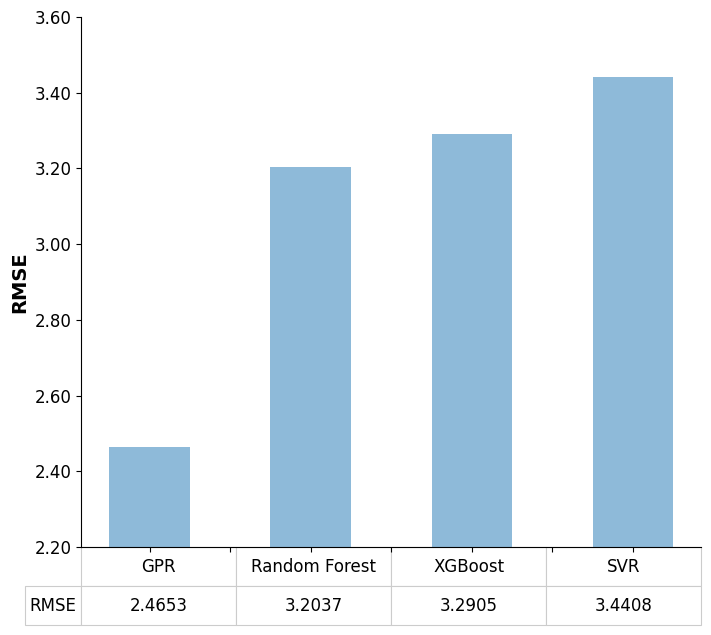

In [ ]:
plot_rmse(
    results_table,
    order=("GPR", "Random Forest", "XGBoost", "SVR"),
    ylim=(2.2, 3.6)
)

# Modified Diebold–Mariano (MDM) test

Two competing forecasts for the same test period:

Model A (GPR)

Model B (RF / SVR / XGB)

Define the loss differential: Squared-error loss (RMSE-based, what the paper uses)

In [ ]:
from scipy.stats import t

def modified_diebold_mariano(y_true, y_pred_1, y_pred_2, h=1, loss="SE"):

    y_true = np.asarray(y_true)
    e1 = y_true - np.asarray(y_pred_1)
    e2 = y_true - np.asarray(y_pred_2)

    if loss == "SE":
        d = e1**2 - e2**2
    elif loss == "AE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("loss must be 'SE' or 'AE'")

    T = len(d)
    d_bar = np.mean(d)

    # HAC variance estimator
    gamma_0 = np.var(d, ddof=1)
    V_d = gamma_0

    DM = d_bar / np.sqrt(V_d / T)

    # Harvey–Leybourne–Newbold correction
    adj = np.sqrt((T + 1 - 2*h + h*(h-1)/T) / T)
    MDM = DM * adj

    p_value = 2 * (1 - t.cdf(np.abs(MDM), df=T-1))

    return MDM, p_value

## Interpretation:

The test-set predictions from the GPR model(s) are obtained by averaging predictions from the ten cross-validated models, and statistical significance of forecast accuracy differences is assessed using the Modified Diebold–Mariano test.

Negative MDM → GPR has lower error

p-value < 0.01 → strong statistical significance

GPR vs Random Forest

In [ ]:
mdm_rf, p_rf = modified_diebold_mariano(
    y_test,
    rf_pred,     # benchmark
    gpr_pred,    # GPR
    h=1,
    loss="SE"
)

print(f"GPR vs RF: MDM = {mdm_rf:.3f}, p-value = {p_rf:.5f}")

GPR vs RF: MDM = 4.968, p-value = 0.00000


GPR vs SVR

In [ ]:
mdm_svr, p_svr = modified_diebold_mariano(
    y_test,
    svr_pred,
    gpr_pred,
    h=1,
    loss="SE"
)

print(f"GPR vs SVR: MDM = {mdm_svr:.3f}, p-value = {p_svr:.5f}")

GPR vs SVR: MDM = 4.005, p-value = 0.00007


GPR vs XGBoost


In [ ]:
mdm_xgb, p_xgb = modified_diebold_mariano(
    y_test,
    xgb_pred,
    gpr_pred,
    h=1,
    loss="SE"
)

print(f"GPR vs XGBoost: MDM = {mdm_xgb:.3f}, p-value = {p_xgb:.5f}")

GPR vs XGBoost: MDM = 4.759, p-value = 0.00000


In [ ]:
def mdm_table(y_true, gpr_pred, benchmarks, h=1, loss="SE"):
    """
    Create a table of Modified Diebold–Mariano test results comparing each benchmark vs GPR.

    benchmarks: dict like {"Random Forest": rf_pred, "SVR": svr_pred, "XGBoost": xgb_pred}
    """
    rows = []

    for name, bench_pred in benchmarks.items():
        stat, p = modified_diebold_mariano(
            y_true=y_true,
            y_pred_1=bench_pred,   # benchmark
            y_pred_2=gpr_pred,     # GPR
            h=h,
            loss=loss
        )

        # significance stars
        if p < 0.001:
            sig = "***"
        elif p < 0.01:
            sig = "**"
        elif p < 0.05:
            sig = "*"
        else:
            sig = ""

        rows.append({
            "Benchmark": name,
            "MDM_stat": stat,
            "p_value": p,
            "sig": sig
        })

    out = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)
    return out

benchmarks = {
    "Random Forest": rf_pred,
    "SVR": svr_pred,
    "XGBoost": xgb_pred
}

mdm_results = mdm_table(y_test, gpr_pred, benchmarks, h=1, loss="SE")

mdm_results_fmt = mdm_results.copy()
mdm_results_fmt["MDM_stat"] = mdm_results_fmt["MDM_stat"].map(lambda x: f"{x:.3f}")
mdm_results_fmt["p_value"]  = mdm_results_fmt["p_value"].map(lambda x: f"{x:.6f}")
mdm_results_fmt

,Benchmark,MDM_stat,p_value,sig
0,Random Forest,4.968,0.000001,***
1,XGBoost,4.759,0.000003,***
2,SVR,4.005,0.000071,***


## Interpretation of MDM (loss differential) results:

Positive MDM_stat ⇒ benchmark has higher loss than GPR

|MDM| > 2 → strong evidence

|MDM| > 3 → very strong

|MDM| ≈ 5 → overwhelming


Because the MDM stats are positive and large, this means that GPR significantly outperforms RF, SVR, and XGBoost